# Multimodal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

## Author(s)
Add your information here

Name: Lauri Heikka

Student number: 2317500

## Description 

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). We are providing the subset of dataset in Moodle.

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification
5. Bonus task: Multimodal biometric identification of persons

where 1-4 are compulsory (max. 10 points each), and 5 is optional to get bonus points (max. 5+5 points). In each phase, you should visualize and analyse the results and document the work and findings properly by text blocks and figures between the code. <b> Nice looking </b> and <b> informative </b> notebook representing your results and analysis will be part of the grading in addition to actual implementation.

The results are validated using confusion matrices and F1 scores. F1 macro score is given as 
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Learning goals 

After the project work, you should  

- be able to study real world multi-modal data
- be able to apply different data fusion techniques to real-world problem
- be able to evaluate the results
- be able to analyse the outcome
- be able to document your work properly

## Relevant lectures

Lectures 1-8

## Relevant exercises

Exercises 0-6

## Relevant chapters in course book

Chapter 1-14

## Additional Material 

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br> 
<p> <b>1.1</b> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>
<br>  
<p> <b>1.2</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>
<br>
<p> <b>1.3</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
<br> 
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [1359]:
import numpy as np
import pandas as pd
from os import listdir,getcwd
    
#Reads data from the folders

def read_data_from_folders(folder_name, ID, outputform):
    output = np.empty(outputform, dtype=object)
    
    for n in range(len(ID)):
        #check files in folder.
        currentDir = getcwd()
        filepath = "%s/%s/%02d" %(currentDir, "MEx/" + folder_name, ID[n])
        files = sorted(listdir(filepath))
        count = 0
        for f in files:
            file = filepath + "/" + f
            data = pd.read_csv(file, delimiter=',', header=None)
            output[n,count] = data 
            count += 1
            
    return output

folders = ['act', 'dc_0.05_0.05']

allData = []
num = 0
ids = np.arange(1,11)

for fol in folders:
    allData.append(read_data_from_folders(fol, ids, (10,8)))

The data is now loaded into a nested array structure containing pandas dataframes. One intuitive way to set up the windowed sampling is to restructure the data to two pandas dataframes with separate id columns allowing us to differentiate between different subjects, exercises and windows. This allows us, for example to better utilize pandas vectorized operations. 

Note that the approach taken here introduces redundant data as the overlapping observation periods are stored separately. A more scalable alternative would be to store the sample indices separately and reference the original data. However, the dataset is small to fit into memory easily, and using the index approach would introduce unnecessary complexity to wrangling the data later.

Let's first create a simple window sampling function, that couples the 

In [1360]:
def window_sample(df, max_time, window=5000, increment=2000):
    # initialize the array of temporary dfs
    temp_dfs = []
    # we use the time information as index for convenience
    df = df.set_index(0)
    sub_id = df.subjectId[0]
    ex_id = df.exerciseId[0]
    for win_start in range(0, max_time-window+1, increment):
        # we need to store the slices by copying instead of pointers
        mask = (df.index >= win_start)&(df.index < win_start+window)
        t_df = df[mask].copy()
        # we store the timewindow information into a string id that containts also information
        # from the 
        t_df['tsId'] = f'{sub_id}_{ex_id}_{str(win_start).zfill(6)}'
        temp_dfs.append(t_df)
    # concat the whole shebang to a dataframe
    return pd.concat(temp_dfs)

In [1361]:
accelData = []
depthData = []
for i in range(len(allData[0])):
    for j in range(len(allData[0][i])):
        allData[0][i][j]['subjectId'] = i+1
        allData[1][i][j]['subjectId'] = i+1
        allData[0][i][j]['exerciseId'] = j+1
        allData[1][i][j]['exerciseId'] = j+1
        # to ensure that we sample the same windows for both datasets
        # we sample windows for the length of the shorter one
        max_time_accel = allData[0][i][j].iloc[-1,0]
        max_time_depth = allData[1][i][j].iloc[-1,0]
        max_time = np.min([max_time_accel, max_time_depth]).astype(int)
        
        accelDf = window_sample(allData[0][i][j], max_time)
        depthDf = window_sample(allData[1][i][j], max_time)
        accelData.append(accelDf)
        depthData.append(depthDf)

accelData = pd.concat(accelData)
depthData = pd.concat(depthData)

Next, we plot some examples from the dataset.

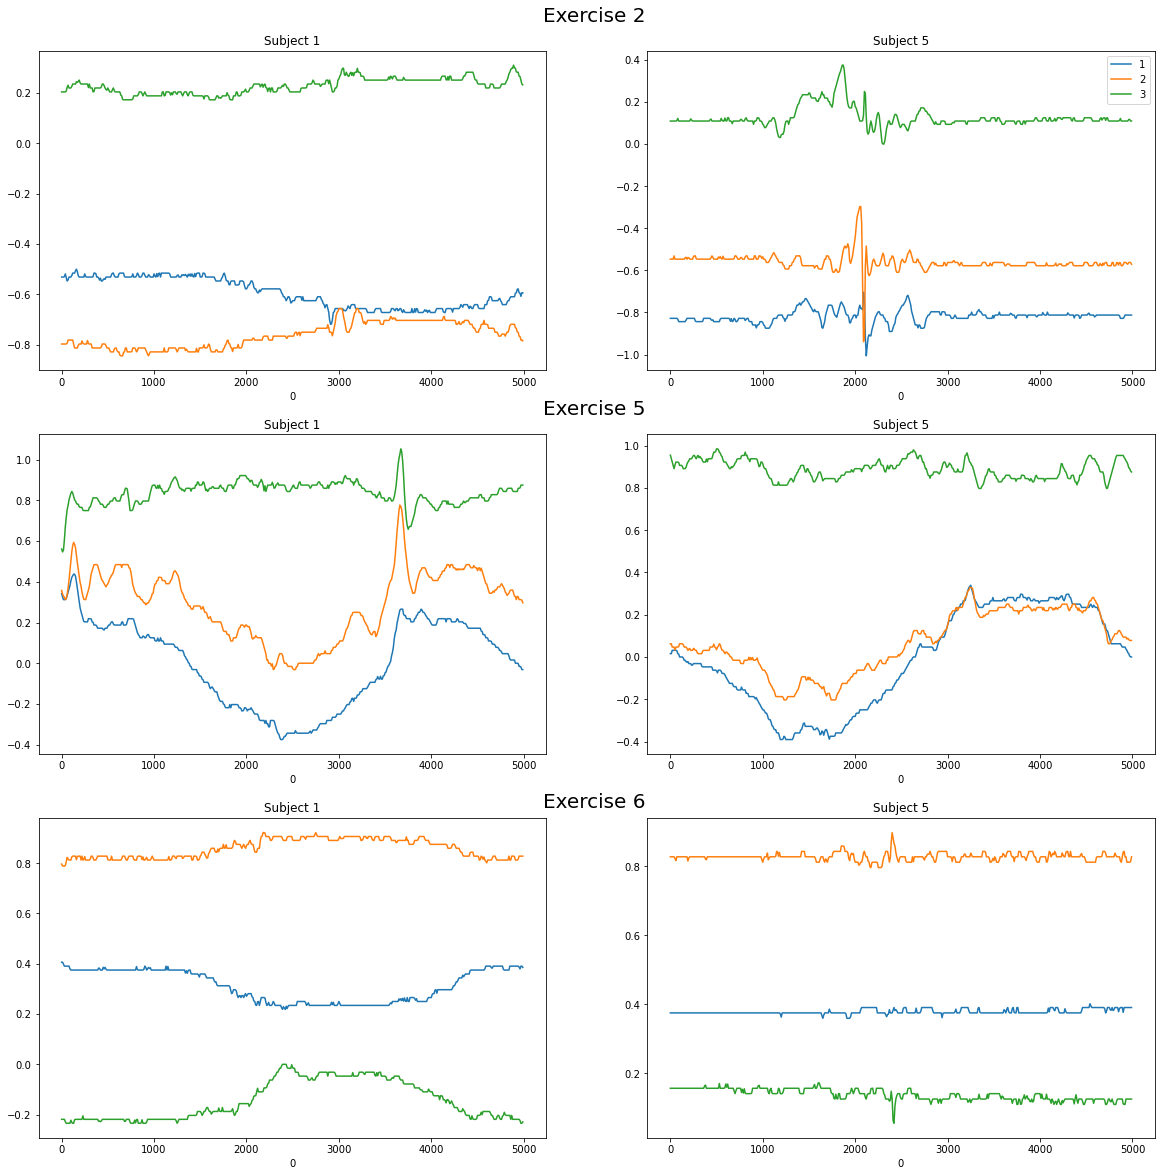

In [1362]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,2, figsize=(20,20))
j = 0
for i in [2,5,6]:
    legend = i == 2
    accelData.loc[accelData.tsId == f'1_{i}_000000',[1,2,3]].plot(ax=ax[j,0], legend=False)
    accelData.loc[accelData.tsId == f'5_{i}_000000',[1,2,3]].plot(ax=ax[j,1], legend=legend)
    ax[j, 0].set_title(f'Subject 1', size='large')
    ax[j, 1].set_title(f'Subject 5',size='large')
    plt.figtext(0.475, .9-j/3.667, f'Exercise {i}', fontsize=20)
    j+=1

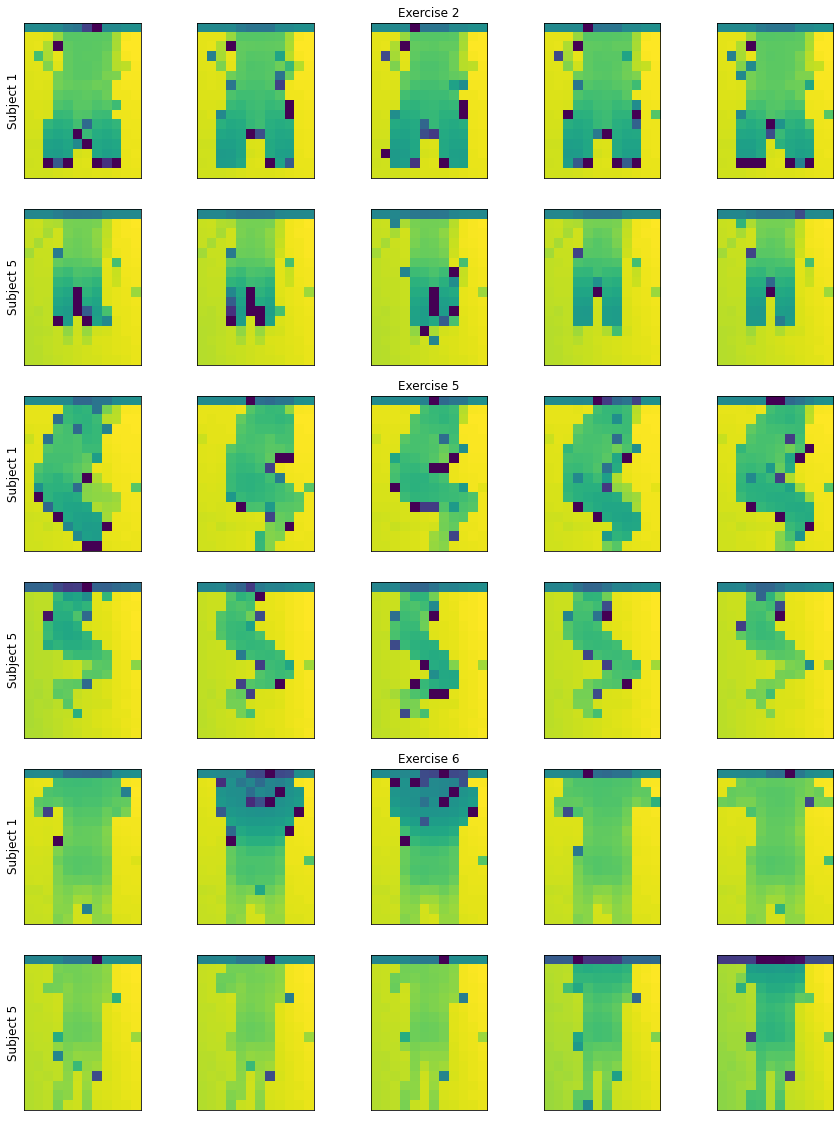

In [1363]:
fig, ax = plt.subplots(6,5, figsize=(15,20))
imgs = 5
for j, i in enumerate([2,5,6]):
    images = depthData.loc[depthData.tsId == f'1_{i}_000000',range(1,193)].values
    for im_n in range(imgs):
        image = images[im_n,:].reshape(12,16).T
        ax[j*2,im_n].imshow(image)
        ax[j*2,im_n].set_xticks([])
        ax[j*2,im_n].set_yticks([])
    ax[j*2,0].set_ylabel('Subject 1', size='large')
    images = depthData.loc[depthData.tsId == f'5_{i}_000000',range(1,193)].values
    for im_n in range(imgs):
        image = images[im_n,:].reshape(12,16).T # transpose turns the images 90 degrees
        ax[j*2+1,im_n].imshow(image)
        ax[j*2+1,im_n].set_xticks([])
        ax[j*2+1,im_n].set_yticks([])
    ax[j*2+1,0].set_ylabel('Subject 5', size='large')
    ax[j*2, 2].set_title(f'Exercise {i}')

1.3 Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.

In [1651]:
trainAccel = accelData[accelData.subjectId <= 7]
testAccel = accelData[accelData.subjectId > 7]
trainDepth = depthData[depthData.subjectId <= 7]
testDepth = depthData[depthData.subjectId > 7]

# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages-19-20) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br>
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br> 
Document your work, evaluate the results, and analyse the outcomes in each subtasks 2.1-2.2.
    
</div>

In [1366]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.signal import resample

In [1652]:
def resample_accel(data, num=125):
    resampledAccel = []
    for i in range(1, 4):
        # create resampled series for each sampled window
        resampled = data.groupby('tsId')[i].apply(lambda x: resample(x, num=125))
        # reformat the resulting series of arrays to one series
        resampled = resampled.apply(pd.Series).stack().reset_index(level=1, drop=True)
        resampledAccel.append(resampled)
    resampledAccel = pd.concat(resampledAccel, axis=1)
    return resampledAccel
trainAccel = resample_accel(trainAccel)
testAccel = resample_accel(testAccel)

In [1653]:
y_train = trainAccel.index.drop_duplicates().str.split('_').str[1].astype(int)
y_test = testAccel.index.drop_duplicates().str.split('_').str[1].astype(int)

In [1645]:
def index_unstack(X, freq=125):
    index_tuples = zip(X.index, len(X)//freq * [i for i in range(freq)])
    X.index = pd.MultiIndex.from_tuples(index_tuples)
    return X.unstack()

In [1646]:
def pca_lda_transform(X_train, X_test, y_train=None, n_components=5, lda=False):
    # standardize
    mu_x = np.mean(X_train.values)
    sigma_x = np.std(X_train.values)
    #mu_x, sigma_x = 0, 1
    X_train = (X_train - mu_x)/sigma_x
    X_test = (X_test - mu_x)/sigma_x
    
    # fit pca and lda
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    
    if lda and y_train is not None:
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        lda.fit(X_train, y_train)   
        train_transformed = np.hstack([pca.transform(X_train), lda.transform(X_train)])
        test_transformed = np.hstack([pca.transform(X_test), lda.transform(X_test)])
    else:
        train_transformed = pca.transform(X_train)
        test_transformed = pca.transform(X_test)
        
    return train_transformed, test_transformed

In [1647]:
X_train_a = []
X_test_a = []
for i in range(3):
    tr_X = index_unstack(trainAccel[i].copy())
    ts_X = index_unstack(testAccel[i].copy())
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, y_train, lda=True)
    X_train_a.append(tr_X)
    X_test_a.append(ts_X)

X_train_a = np.hstack(X_train_a)
X_test_a = np.hstack(X_test_a)

In [1371]:
pca_inds = [(i // 5)%2 == 0 for i in range(30)]
lda_inds = [not ind for ind in pca_inds]

def compute_distances(x, X):
    d_n = ((x - X)**2).sum(1)
    d_n = (d_n - d_n.min())/(d_n.max()-d_n.min())
    return d_n
def predict_nn(test_x, pca_inds, lda_inds):
    F_n = np.mean([compute_distances(test_x[pca_inds], X_train_a[:,pca_inds]),
             compute_distances(test_x[lda_inds], X_train_a[:,lda_inds])], 0)
    return F_n.argmin()

y_pred = y_train[np.apply_along_axis(lambda x: predict_nn(x, pca_inds, lda_inds), 1, X_test_a)]

F1 Score: 0.454
[[10 10 36  0  0  3 26  0]
 [ 1 31 11  0  0 13 23  5]
 [ 0 30 23  0  0  4 23  6]
 [ 2  0  0 43  1  1  0  0]
 [ 1  0  0 15 10  7  0  0]
 [ 0 31  2  0  0 57  0  0]
 [ 0 21  5  0  0  0 59  3]
 [ 0 16  3  0  0  2 32 32]]


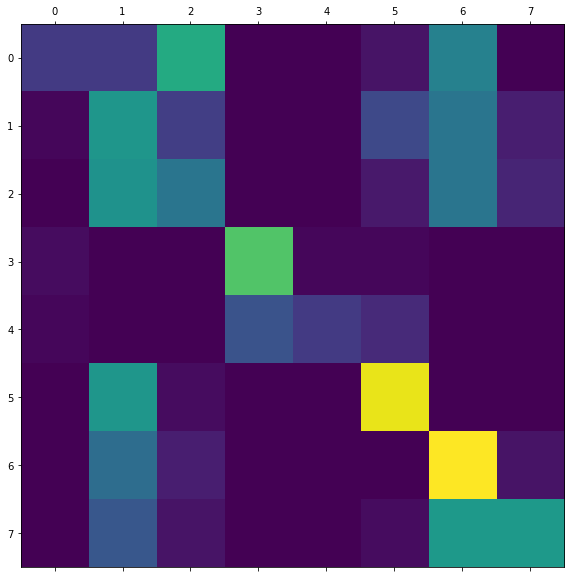

In [1372]:
from sklearn.metrics import f1_score, confusion_matrix
print('F1 Score: {:.03f}'.format(f1_score(y_test, y_pred, average='macro')))
conf_m = confusion_matrix(y_test, y_pred)
print(conf_m)
fig, ax = plt.subplots(1, figsize=(10,10))
ax.matshow(conf_m)

Previously, we worked on using PCA and LDA to reduce dimensionality in the time dimension. However, now we instead reduce the dimensionality of the pixel space.

There are two alternative methods to set up the dimensionality reduction. First, we can conduct the dimension reduction separately for each image in the sequence such, that images are only compared to other images at that same point in time. This is essentially making the assumption that each image in the sequence is a separate feature and images are. One potential implementation of this is as follows:


In [1373]:
X_train_d = []
X_test_d = []
for i in range(5):
    tr_X = trainDepth.iloc[i::5,:192]
    ts_X = testDepth.iloc[i::5,:192]
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, y_train, lda=True)
    X_train_d.append(tr_X)
    X_test_d.append(ts_X)

X_train_d = np.hstack(X_train_d)
X_test_d = np.hstack(X_test_d)

An alternative would be to treat the image data globally, so that all images are compared to all other images regardless of the point in time.
This can be implemented as follows:

In [1374]:
X_train_d_global, X_test_d_global = pca_lda_transform(trainDepth.iloc[:,:192], testDepth.iloc[:,:192],
                                        trainDepth.tsId.str.split('_').str[1], n_components=5, lda=True)

X_train_d_global = np.hstack([X_train_d_global[i::5,:] for i in range(5)])
X_test_d_global = np.hstack([X_test_d_global[i::5,:] for i in range(5)])

Arguably, the selection of which method to choose can be taken as an empirical question.

In [1375]:
pca_inds = [(i // 5)%2 == 0 for i in range(50)]
lda_inds = [not ind for ind in pca_inds]

def compute_distances(x, X):
    d_n = ((x - X)**2).sum(1)
    d_n = (d_n - d_n.min())/(d_n.max()-d_n.min())
    return d_n
def predict_nn(test_x, train_X, pca_inds, lda_inds):
    F_n = np.mean([compute_distances(test_x[pca_inds], train_X[:,pca_inds]),
             compute_distances(test_x[lda_inds], train_X[:,lda_inds])], 0)
    return F_n.argmin()

In [1376]:
y_pred = y_train[np.apply_along_axis(lambda x: predict_nn(x, X_train_d, pca_inds, lda_inds), 1, X_test_d)]
y_pred2 = y_train[np.apply_along_axis(lambda x: predict_nn(x, X_train_d_global, pca_inds, lda_inds),
                                      1, X_test_d_global)]

print('F1 Score with local PCA/LDA: {:.03f}'.format(f1_score(y_test, y_pred, average='macro')))
print('F1 Score with global PCA/LDA: {:.03f}'.format(f1_score(y_test, y_pred2, average='macro')))

F1 Score with local PCA/LDA: 0.426
F1 Score with global PCA/LDA: 0.407


The local version seems to perform slightly better. For brevity, we will stick to this implementation from now on.

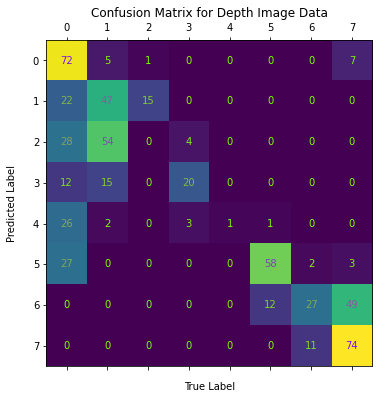

In [1379]:
# we only show the confusion matrix for the btter performing alternative
conf_m = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(1, figsize=(6,6))
ax.set_xlabel('\nTrue Label')
ax.set_ylabel('Predicted Label\n')
ax.set_title('Confusion Matrix for Depth Image Data')
for (i, j), z in np.ndenumerate(conf_m):
    cval = (z/77)
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center', c=[0.5, 1-cval, cval])
ax.matshow(conf_m)

# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as
<br>   
<br> 
<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>
<br>  
<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>
<br> 
<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>
<br> 
Document your work, evaluate the results, and analyse the outcomes in each subtasks 3.1-3.3.
    
</div>

In [1380]:
X_train_a = []
X_test_a = []
for i in range(3):
    tr_X = index_unstack(trainAccel[i].copy())
    ts_X = index_unstack(testAccel[i].copy())
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, n_components=10, lda=False)
    X_train_a.append(tr_X)
    X_test_a.append(ts_X)

X_train_a = np.hstack(X_train_a)
X_test_a = np.hstack(X_test_a)
X_train_a = np.hstack([X_train_a, trainAccel.groupby('tsId').agg(['mean','std'])])
X_test_a =  np.hstack([X_test_a, testAccel.groupby('tsId').agg(['mean','std'])])

In [1382]:
X_train_d = []
X_test_d = []
for i in range(5):
    tr_X = trainDepth.iloc[i::5,:192]
    ts_X = testDepth.iloc[i::5,:192]
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, n_components=10, lda=False)
    X_train_d.append(tr_X)
    X_test_d.append(ts_X)

X_train_d = np.hstack(X_train_d)
X_test_d = np.hstack(X_test_d)

<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>
<br> 
Document your work, evaluate the results, and analyse the outcomes in each subtasks 3.1-3.3.
    
</div>

In [1383]:
X_train = np.hstack([X_train_a, X_train_d])
X_test = np.hstack([X_test_a, X_test_d])

In [1384]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix

SVM F1: 0.515
GNB F1: 0.707


Text(0.5, 1.0, 'Naive Bayes')

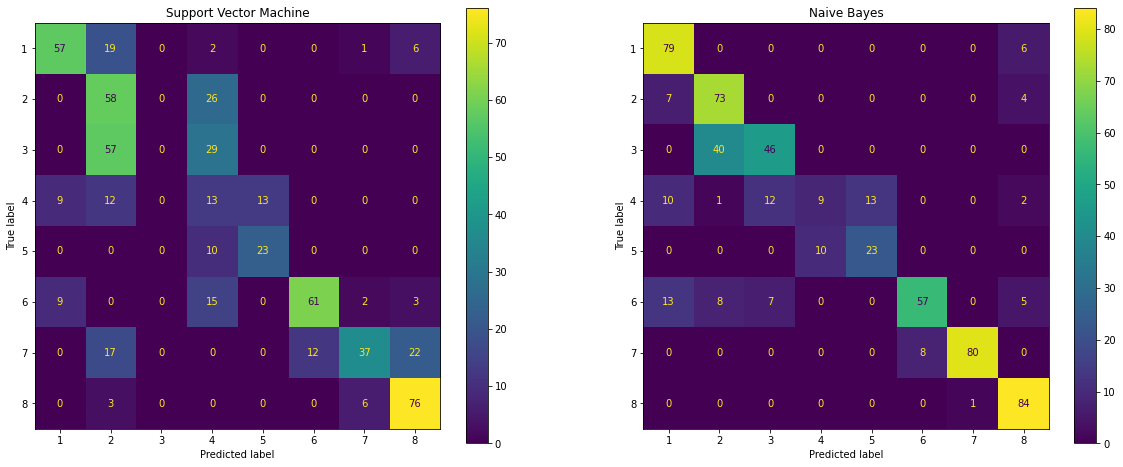

In [1385]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC()
gnb = GaussianNB()

svc.fit(X_train, y_train)
gnb.fit(X_train, y_train)

print('SVM F1: {:.03f}'.format(f1_score(y_test, svc.predict(X_test), average='macro')))
print('GNB F1: {:.03f}'.format(f1_score(y_test, gnb.predict(X_test), average='macro')))

fig, ax = plt.subplots(1,2, figsize=(20, 8))

plot_confusion_matrix(svc, X_test, y_test, ax=ax[0])
ax[0].set_title('Support Vector Machine')
plot_confusion_matrix(gnb, X_test, y_test, ax=ax[1])
ax[1].set_title('Naive Bayes')

# 4. Decision-level fusion for multimodal classification

<a id='task4'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 4.</b>

Use features calculated for each modality in task 3. Choose base classifier for each modality from scikit-learn. Train classifiers for each modality feature presentations separately and combine the outputs in decision level. Evaluate and compare the result on testing dataset. Do the subtasks given as
<br>
<br> 
<p> <b>4.1</b> Use base classifiers of support vector machine (SVM) with RBF-kernel and AdaBoost classifier (with random_state=0). 
Normalize data between 0-1 using the training dataset. Train the base classifiers by tuning the model parameters (<i>C</i> parameter and RBF-kernel <i>gamma</i> in SVM as well as <i>n_estimators</i> and <i>learning_rate</i> in Adaboost) using 10-fold cross-validation on training dataset to find optimal set of parameters (hint: use GridSearchCV from scikit-learn). For grid search use the following values $C = [0.1, 1.0, 10.0, 100.0]$, $gamma=[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]$, $n\_estimators = [50, 100, 500, 1000]$, and $learning\_rate = [0.1, 0.25, 0.5, 0.75,1.0]$. Choose the best parameters and train the classifiers for each modality on whole training dataset. Is there a possibility that classifiers will overfit to training data using this parameter selection strategy? If so, why? </p>
<br>
<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
<p> <b>4.3</b> Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>
<br>
Document your work, evaluate the results, and analyse the outcomes in each subtasks 4.1-4.3.
    
</div>

Selecting hyperparameters based on training set performance, is essentially fitting parameters to the training data, so theoretically yes. However, with such a small grid of hyperparameters to choose from and 10 out-of-sample folds, any meaningful degree of overfit is unlikely.

In [1386]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
param_grid_svc = {
    'C':[0.1,1.0,10.0,100.0], 
    'gamma':[0.1,0.25,0.5,0.75,1.0,2.0],
}
scaler = MinMaxScaler()
X_train_d = scaler.fit_transform(X_train_d)
X_test_d = scaler.transform(X_test_d)
scaler = MinMaxScaler()
X_train_a = scaler.fit_transform(X_train_a)
X_test_a = scaler.transform(X_test_a)

In [1387]:
svc = SVC(probability=True)
svm_cv_acc = GridSearchCV(svc, param_grid_svc, cv=10, n_jobs=4)
svm_cv_acc.fit(X_train_a, y_train)
print('SVM Acceleration F1: {:.03f}'.format(f1_score(y_test, svm_cv_acc.predict(X_test_a), average='macro')))

SVM Acceleration F1: 0.564


In [1388]:
svc = SVC(probability=True)
svm_cv_d = GridSearchCV(svc, param_grid_svc, cv=10, n_jobs=4)
svm_cv_d.fit(X_train_d, y_train)
print('SVM Depth Camera F1: {:.03f}'.format(f1_score(y_test, svm_cv_d.predict(X_test_d), average='macro')))

SVM Depth Camera F1: 0.424


In [1389]:
param_grid_ada = {'n_estimators':[50,100,500,1000],
    'learning_rate':[0.1,0.25,0.5,0.75,1.0]
}

In [1390]:
ada = AdaBoostClassifier(random_state=0)
cv_ada_acc = GridSearchCV(ada, param_grid_ada, cv=10, n_jobs=4, verbose=True)
cv_ada_acc.fit(X_train_a, y_train)
print('Adaboost Acceleration F1: {:.03f}'.format(f1_score(y_test, cv_ada_acc.predict(X_test_a), average='macro')))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.4min finished


Adaboost Acceleration F1: 0.412


In [1391]:
ada = AdaBoostClassifier(random_state=0)
cv_ada_d = GridSearchCV(ada, param_grid_ada, cv=10, n_jobs=4, verbose=True)
cv_ada_d.fit(X_train_d, y_train)
f1_adad = f1_score(y_test, cv_ada_d.predict(X_test_d), average='macro')
print('Adaboost Depth Camera F1: {:.03f}'.format(f1_adad))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  5.6min finished


Adaboost Depth Camera F1: 0.416


Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>

In [1392]:
svm_proba_a = svm_cv_acc.predict_proba(X_test_a)
ada_proba_a = cv_ada_acc.predict_proba(X_test_a)
svm_proba_d = svm_cv_d.predict_proba(X_test_d)
ada_proba_d = cv_ada_d.predict_proba(X_test_d)

In [1393]:
from itertools import combinations

,max,min,product,sum
svm_acc + adaboost_depth,0.570372,0.682014,0.669941,0.587844
svm_acc + svm_depth,0.575685,0.625402,0.615620,0.590626
adaboost_acc + svm_depth,0.454015,0.509047,0.498895,0.479112
adaboost_acc + adaboost_depth,0.452185,0.443092,0.448032,0.444712


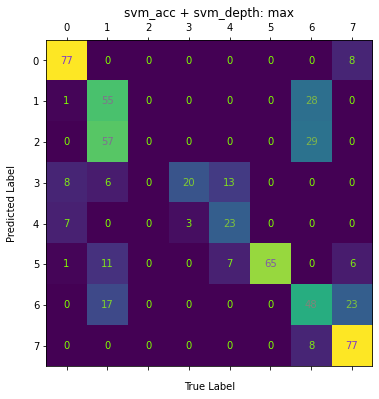

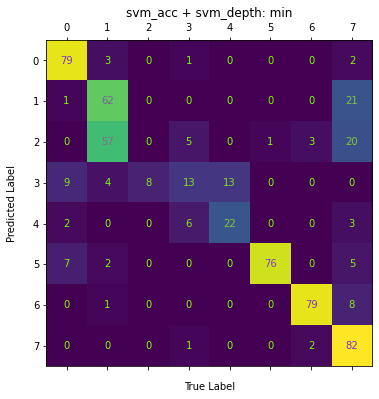

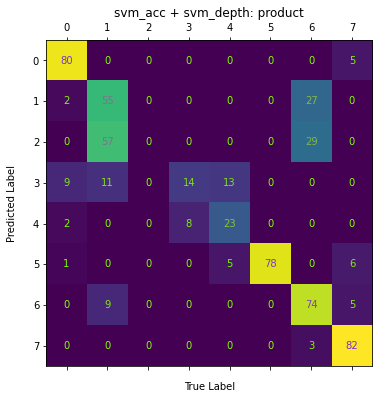

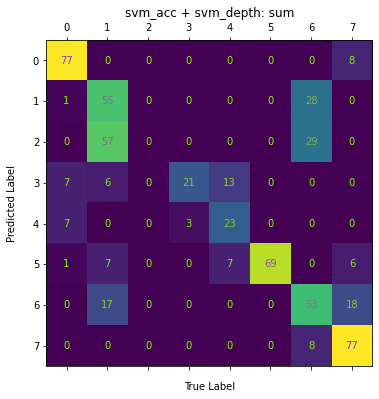

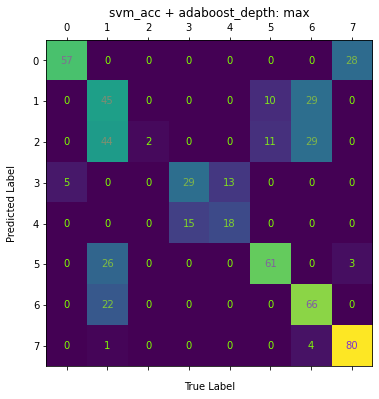

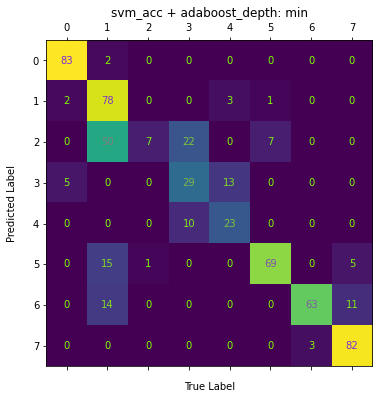

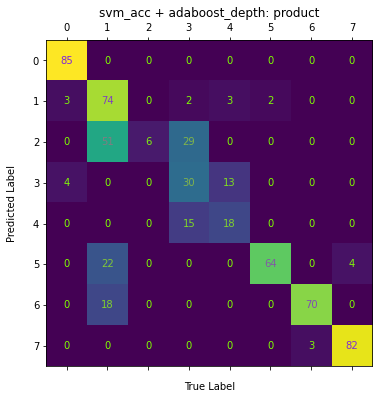

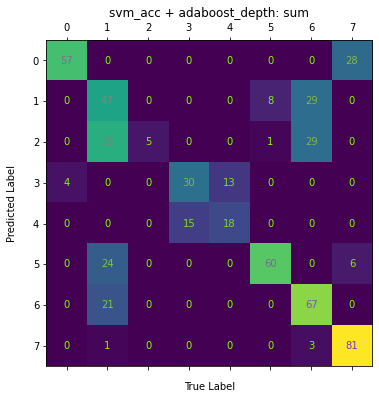

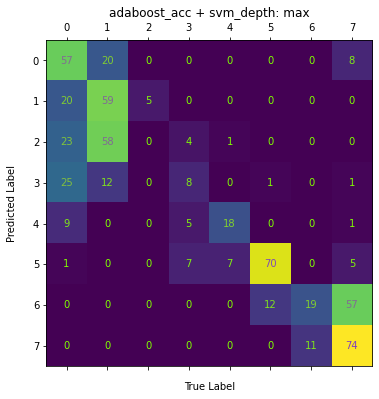

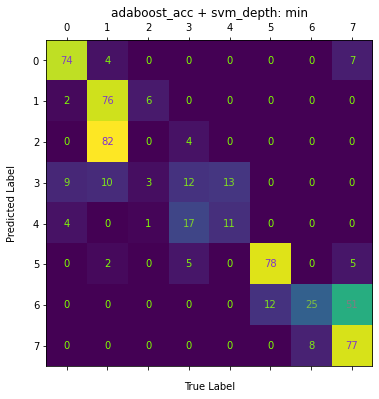

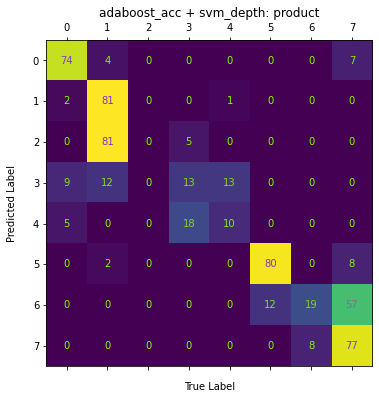

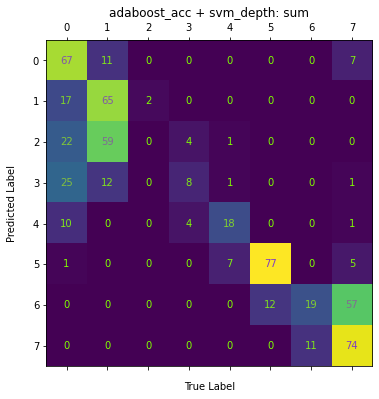

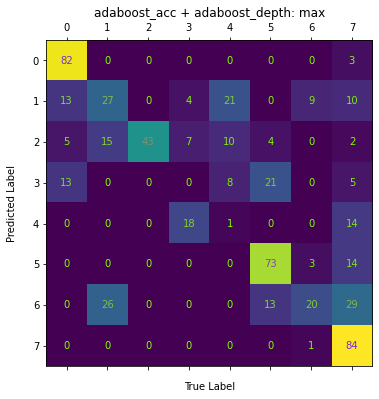

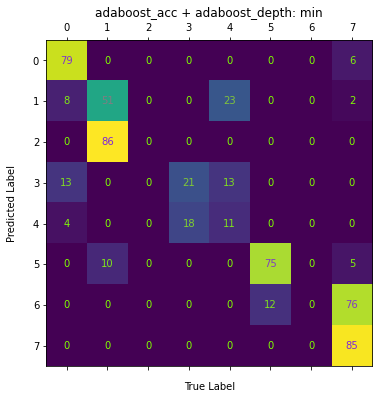

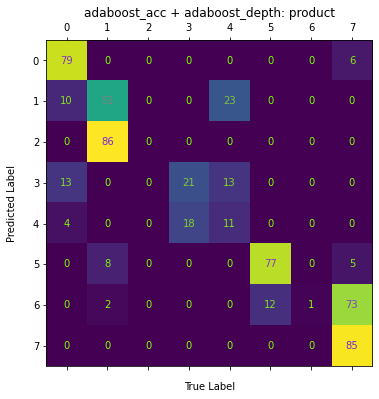

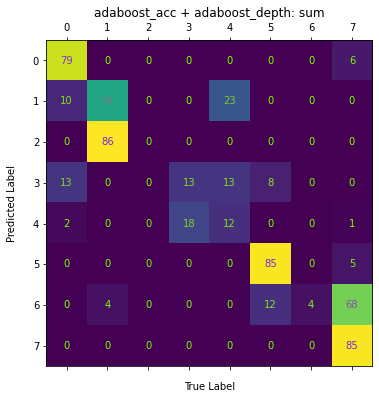

In [1394]:
proba_outputs = {
    'svm_acc':svm_proba_a,
    'svm_depth':svm_proba_d,
    'adaboost_acc':ada_proba_a,
    'adaboost_depth':ada_proba_d,
}
f1_scores = {}
functions = {
    'max':np.max,
    'min':np.min,
    'product': np.prod,
    'sum': np.sum}
acc_probas = ['svm_acc', 'adaboost_acc']
depth_probas = ['svm_depth','adaboost_depth']

for acc_clf in acc_probas:
    for depth_clf in depth_probas:
        f1_scores[f'{acc_clf} + {depth_clf}'] = {}
        prob_comb = np.array([proba_outputs[acc_clf], proba_outputs[depth_clf]])
        for func_name, func in functions.items():
            probs = func(prob_comb, axis=0)
            preds = np.argmax(probs, 1)+1 ## +1 is a dirty trick to transfer argmax output to class numbers
            f1_scores[f'{acc_clf} + {depth_clf}'][f'{func_name}'] = f1_score(y_test, preds, average='macro')
            conf_m = confusion_matrix(y_test, preds)
            fig, ax = plt.subplots(1, figsize=(6,6))
            ax.set_xlabel('\nTrue Label')
            ax.set_ylabel('Predicted Label\n')
            ax.set_title(f'{acc_clf} + {depth_clf}: {func_name}')
            for (i, j), z in np.ndenumerate(conf_m):
                cval = (z/100)
                ax.text(j, i, '{:d}'.format(z), ha='center', va='center', c=[0.5, 1-cval, cval])
            ax.matshow(conf_m)
            
f1_scores = pd.DataFrame(f1_scores).T
f1_scores.loc[f1_scores.max(1).sort_values(ascending=False).index,:]

In [1395]:
f1_scores = {}
for i in range(2,5):
    for keys in combinations(proba_outputs.keys(), i):
        f1_scores[f'{keys}'] = {}
        prob_comb = np.array([proba_outputs[k] for k in keys])
        for func_name, func in functions.items():
            probs = func(prob_comb, axis=0)
            preds = np.argmax(probs, 1)+1 ## +1 is a dirty trick to transfer argmax output to class numbers
            f1_scores[f'{keys}'][f'{func_name}'] = f1_score(y_test, preds, average='macro')
f1_scores = pd.DataFrame(f1_scores).T
f1_scores.loc[f1_scores.max(1).sort_values(ascending=False).index,:]

,max,min,product,sum
"('svm_acc', 'adaboost_depth')",0.570372,0.682014,0.669941,0.587844
"('svm_acc', 'adaboost_acc', 'adaboost_depth')",0.555372,0.632991,0.663070,0.576641
"('svm_acc', 'svm_depth', 'adaboost_acc', 'adaboost_depth')",0.574257,0.622072,0.646720,0.584697
"('svm_acc', 'svm_depth', 'adaboost_depth')",0.575685,0.645989,0.614309,0.543639
"('svm_acc', 'svm_depth')",0.575685,0.625402,0.615620,0.590626
"('svm_acc', 'svm_depth', 'adaboost_acc')",0.574257,0.597164,0.624913,0.619264
"('svm_acc', 'adaboost_acc')",0.553358,0.556728,0.551149,0.562120
"('svm_depth', 'adaboost_acc')",0.454015,0.509047,0.498895,0.479112
"('svm_depth', 'adaboost_acc', 'adaboost_depth')",0.454015,0.494286,0.492104,0.474112
"('adaboost_acc', 'adaboost_depth')",0.452185,0.443092,0.448032,0.444712


# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br> 
<br> 
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br> 
<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>  
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

The time information is in the 

In [1655]:
durations = accelData.reset_index().groupby(['subjectId','exerciseId'])[0].transform(lambda x: x/x.max())
accelData['timepos'] = durations.values
durations = depthData.reset_index().groupby(['subjectId','exerciseId'])[0].transform(lambda x: x/x.max())
depthData['timepos'] = durations.values

In [1656]:
train_ids = (accelData.groupby(['tsId'])['timepos'].agg('max') < 0.25)
train_ids = train_ids&(depthData.groupby(['tsId'])['timepos'].agg('max') < 0.25)
train_ids = train_ids[train_ids].index
trainAccel = accelData[accelData.tsId.isin(train_ids)]
trainDepth = depthData[depthData.tsId.isin(train_ids)]

test_ids = (accelData.groupby(['tsId'])['timepos'].agg('min') > 0.25)
test_ids = test_ids&(depthData.groupby(['tsId'])['timepos'].agg('min') > 0.25)
test_ids = test_ids[test_ids].index
testAccel = accelData[accelData.tsId.isin(test_ids)]
testDepth = depthData[depthData.tsId.isin(test_ids)]

In [1657]:
trainAccel = resample_accel(trainAccel)
testAccel = resample_accel(testAccel)
y_train = trainAccel.index.drop_duplicates().str.split('_').str[0].astype(int)
y_test = testAccel.index.drop_duplicates().str.split('_').str[0].astype(int)

In [1659]:
X_train_a = []
X_test_a = []
for i in range(3):
    tr_X = index_unstack(trainAccel[i].copy())
    ts_X = index_unstack(testAccel[i].copy())
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, n_components=10, lda=False)
    X_train_a.append(tr_X)
    X_test_a.append(ts_X)

X_train_a = np.hstack(X_train_a)
X_test_a = np.hstack(X_test_a)
X_train_a = np.hstack([X_train_a, trainAccel.groupby('tsId').agg(['mean','std'])])
X_test_a =  np.hstack([X_test_a, testAccel.groupby('tsId').agg(['mean','std'])])

X_train_d = []
X_test_d = []
for i in range(5):
    tr_X = trainDepth.iloc[i::5,:192]
    ts_X = testDepth.iloc[i::5,:192]
    tr_X, ts_X = pca_lda_transform(tr_X, ts_X, n_components=10, lda=False)
    X_train_d.append(tr_X)
    X_test_d.append(ts_X)

X_train_d = np.hstack(X_train_d)
X_test_d = np.hstack(X_test_d)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
param_grid_svc = {
    'C':[0.1,1.0,10.0,100.0], 
    'gamma':[0.1,0.25,0.5,0.75,1.0,2.0],
}
scaler = MinMaxScaler()
X_train_d = scaler.fit_transform(X_train_d)
X_test_d = scaler.transform(X_test_d)
scaler = MinMaxScaler()
X_train_a = scaler.fit_transform(X_train_a)
X_test_a = scaler.transform(X_test_a)
svc = SVC(probability=True)
svm_cv_acc = GridSearchCV(svc, param_grid_svc, cv=10, n_jobs=4)
svm_cv_acc.fit(X_train_a, y_train)
print('SVM Acceleration F1: {:.03f}'.format(f1_score(y_test, svm_cv_acc.predict(X_test_a), average='macro')))
ada = AdaBoostClassifier(random_state=0)
cv_ada_d = GridSearchCV(ada, param_grid_ada, cv=10, n_jobs=4, verbose=True)
cv_ada_d.fit(X_train_d, y_train)
print('Adaboost Depth Image F1: {:.03f}'.format(f1_score(y_test, cv_ada_d.predict(X_test_d), average='macro')))

In [1661]:
svm_proba_a = svm_cv_acc.predict_proba(X_test_a)
ada_proba_d = cv_ada_d.predict_proba(X_test_d)